In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys

In [57]:
sys.path.append(r'c:\Users\Hanss\Documents\Data Science Project\predictive-maintenance\src\Data processing scripts')

In [58]:
from CSV_module import CSVReader
from PreProcess_module import PreProcessor
from SQL_module import SQLManager  
from Logging_module import LoggerSetup

In [59]:
file_urls = [
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_errors.csv",
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_failures.csv",
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_machines.csv",
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_maint.csv",
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_telemetry.csv"
    
]

csv_reader = CSVReader(file_urls, 'csv_reader_log.log')
dataframes = csv_reader.read_csv_files()


df1 = dataframes.get('PdM_errors')
df2 = dataframes.get('PdM_failures')
df3 = dataframes.get('PdM_machines')
df4 = dataframes.get('PdM_maint')
df5 = dataframes.get('PdM_telemetry')



In [60]:
preprocessor_df1 = PreProcessor(df1)
cleaned_df1 = preprocessor_df1.clean_data()  

preprocessor_df2 = PreProcessor(df2)
cleaned_df2 = preprocessor_df2.clean_data() 

preprocessor_df3 = PreProcessor(df3) 
cleaned_df3 = preprocessor_df3.clean_data() 

preprocessor_df4 = PreProcessor(df4) 
cleaned_df4 = preprocessor_df4.clean_data() 

preprocessor_df5 = PreProcessor(df5) 
cleaned_df5 = preprocessor_df5.clean_data() 

In [61]:
cleaned_df1['date'] = cleaned_df1['date'].astype(str)
cleaned_df1['time'] = cleaned_df1['time'].astype(str)
cleaned_df1['datetime'] = pd.to_datetime(cleaned_df1['date'] + ' ' + cleaned_df1['time'])
cleaned_df1 = cleaned_df1.drop(columns=['date', 'time'])

cleaned_df1 = cleaned_df1.sort_values(by=['machineID', 'datetime'])

cleaned_df1['component_error_count'] = cleaned_df1.groupby(['machineID', 'errorID']).cumcount() + 1



#----------------------------------------------------------------------------------------------------------------------------------------------------

cleaned_df2['date'] = cleaned_df2['date'].astype(str)
cleaned_df2['time'] = cleaned_df2['time'].astype(str)
cleaned_df2['datetime'] = pd.to_datetime(cleaned_df2['date'] + ' ' + cleaned_df2['time'])
cleaned_df2 = cleaned_df2.drop(columns=['date', 'time'])

cleaned_df2['failure'] = cleaned_df2['failure'].apply(lambda x: 'fail_' + x)
cleaned_df2 = cleaned_df2.sort_values(by=['machineID', 'datetime'])

cleaned_df2['component_failure_count'] = cleaned_df2.groupby(['machineID', 'failure']).cumcount() + 1



#----------------------------------------------------------------------------------------------------------------------------------------------------

cleaned_df4['date'] = cleaned_df4['date'].astype(str)
cleaned_df4['time'] = cleaned_df4['time'].astype(str)
cleaned_df4['datetime'] = pd.to_datetime(cleaned_df4['date'] + ' ' + cleaned_df4['time'])
cleaned_df4 = cleaned_df4.drop(columns=['date', 'time'])

cleaned_df4['comp'] = cleaned_df4['comp'].apply(lambda x: 'maint_' + x)
cleaned_df4= cleaned_df4.sort_values(by=['machineID', 'datetime'])

cleaned_df4['maint_comp_count'] = cleaned_df4.groupby(['machineID', 'comp']).cumcount() + 1


#------------------------------------------------------------------------------------------------------------------------------------------------------

cleaned_df5['date'] = cleaned_df5['date'].astype(str)
cleaned_df5['time'] = cleaned_df5['time'].astype(str)
cleaned_df5['datetime'] = pd.to_datetime(cleaned_df5['date'] + ' ' + cleaned_df5['time'])
cleaned_df5 = cleaned_df5.drop(columns=['date', 'time'])

cleaned_df5 = cleaned_df5.sort_values(by=['machineID', 'datetime'])





In [62]:
# Reorganizing data to be able to find out how many failures, errors and maintenance there were per day and then every month to 
# to be able to see the changes over time.

errors_resampled_days = cleaned_df1.set_index('datetime').groupby('errorID').resample('D').sum()['component_error_count'].unstack().fillna(0)

failures_resampled_days = cleaned_df2.set_index('datetime').groupby('failure').resample('D').sum()['component_failure_count'].unstack().fillna(0)

maintenance_resampled_days = cleaned_df4.set_index('datetime').groupby('comp').resample('D').size().unstack().fillna(0)


#-------------------------------------------------------------------------------------------------------------------------------------------------------

errors_resampled_month_end = cleaned_df1.set_index('datetime').groupby('errorID').resample('ME').sum()['component_error_count'].unstack().fillna(0)
errors_resampled_month_end.columns = errors_resampled_month_end.columns.strftime('%Y-%m')

failures_resampled_month_end = cleaned_df2.set_index('datetime').groupby('failure').resample('ME').sum()['component_failure_count'].unstack().fillna(0)
failures_resampled_month_end.columns = failures_resampled_month_end.columns.strftime('%Y-%m')

maintenance_resampled_month_end = cleaned_df4.set_index('datetime').groupby('comp').resample('ME').size().unstack().fillna(0)
maintenance_resampled_month_end.columns = maintenance_resampled_month_end.columns.strftime('%Y-%m')


In [63]:
# Combines two dataframes and groups their data by month-end to see how errors, failures, and maintenance relate to each other on a monthly basis.

error_maint_combined_df = pd.concat([maintenance_resampled_month_end, errors_resampled_month_end], axis=1).T.fillna(0)
error_maint_combined_df.index = pd.to_datetime(error_maint_combined_df.index)
error_maint_combined_df = error_maint_combined_df.groupby(pd.Grouper(freq='ME')).sum()

#-------------------------------------------------------------------------------------------------------------------------------------------

failure_maint_combined_df = pd.concat([maintenance_resampled_month_end, failures_resampled_month_end], axis=1).T.fillna(0)
failure_maint_combined_df.index = pd.to_datetime(failure_maint_combined_df.index)
failure_maint_combined_df = failure_maint_combined_df.groupby(pd.Grouper(freq='ME')).sum()

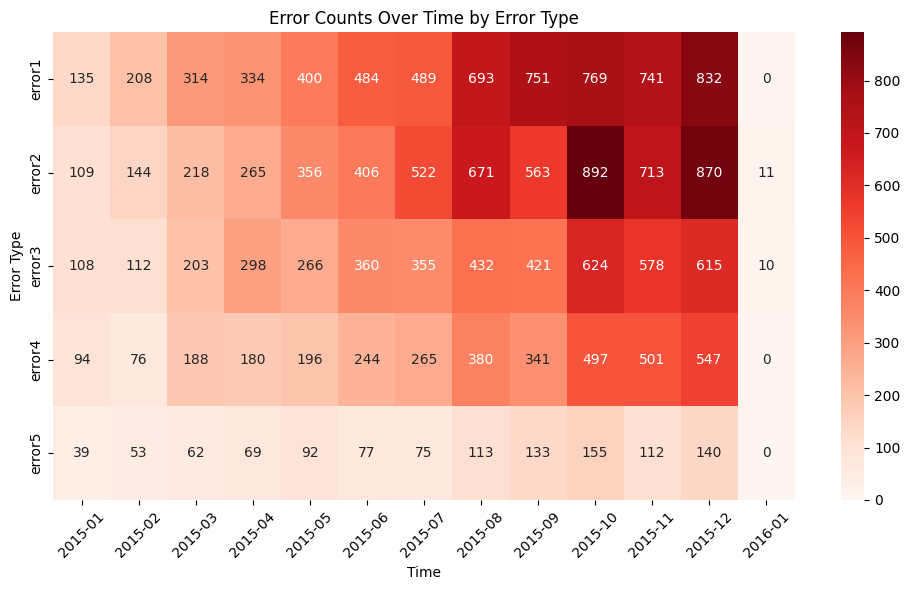

In [64]:
# Heatmap to show different error types over time.

plt.figure(figsize=(10, 6))

sns.heatmap(errors_resampled_month_end, cmap="Reds", annot=True, cbar=True, fmt='g')


plt.title('Error Counts Over Time by Error Type')
plt.xlabel('Time')
plt.ylabel('Error Type')


plt.xticks(rotation=45)

plt.tight_layout()  
plt.show()

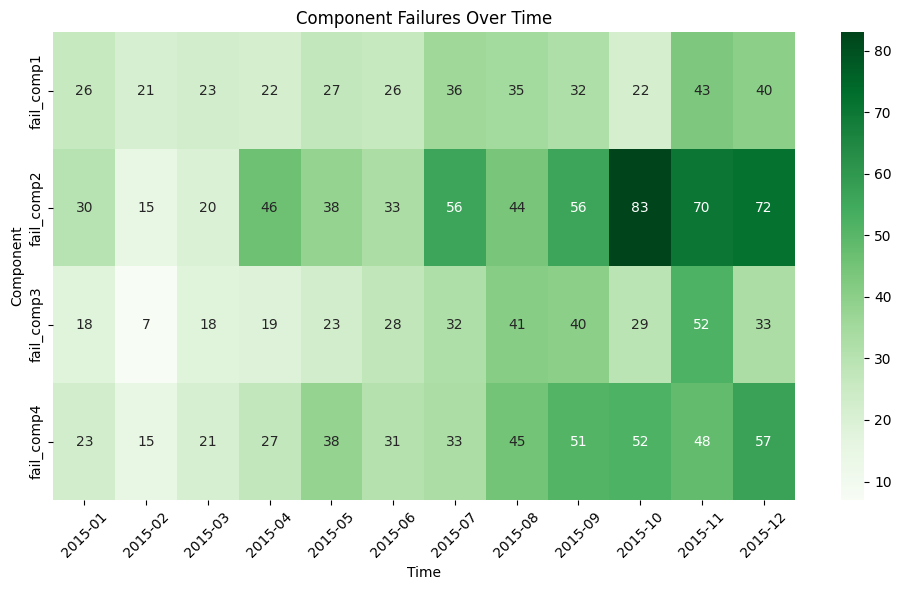

In [65]:
# Heatmap to show different component failures over time.

plt.figure(figsize=(10, 6))

sns.heatmap(failures_resampled_month_end, cmap="Greens", cbar=True, annot=True)

plt.title('Component Failures Over Time')
plt.xlabel('Time')
plt.ylabel('Component')

plt.xticks(rotation=45)

plt.tight_layout() 
plt.show()

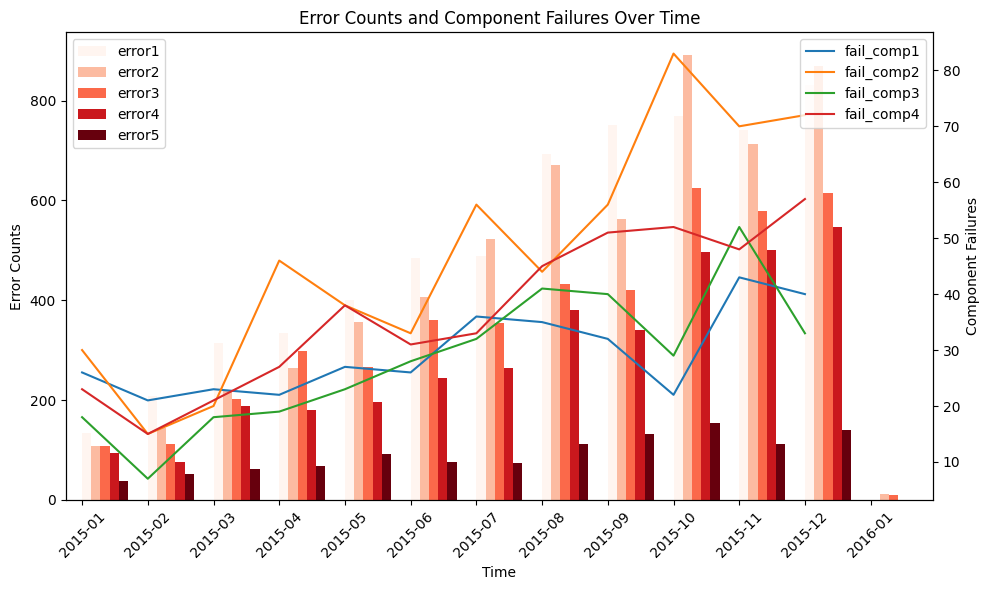

In [66]:
#Shows how many errors each month and how many failures each month to see if they are related.

fig, ax1 = plt.subplots(figsize=(10, 6))

errors_resampled_month_end.T.plot(kind='bar', ax=ax1, width=0.7, position=0, colormap='Reds')

plt.xticks(rotation=45)
ax2 = ax1.twinx()

for column in failures_resampled_month_end.T.columns:
    ax2.plot(failures_resampled_month_end.T.index, failures_resampled_month_end.T[column], label=column)


ax1.set_title('Error Counts and Component Failures Over Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Error Counts')
ax2.set_ylabel('Component Failures')


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


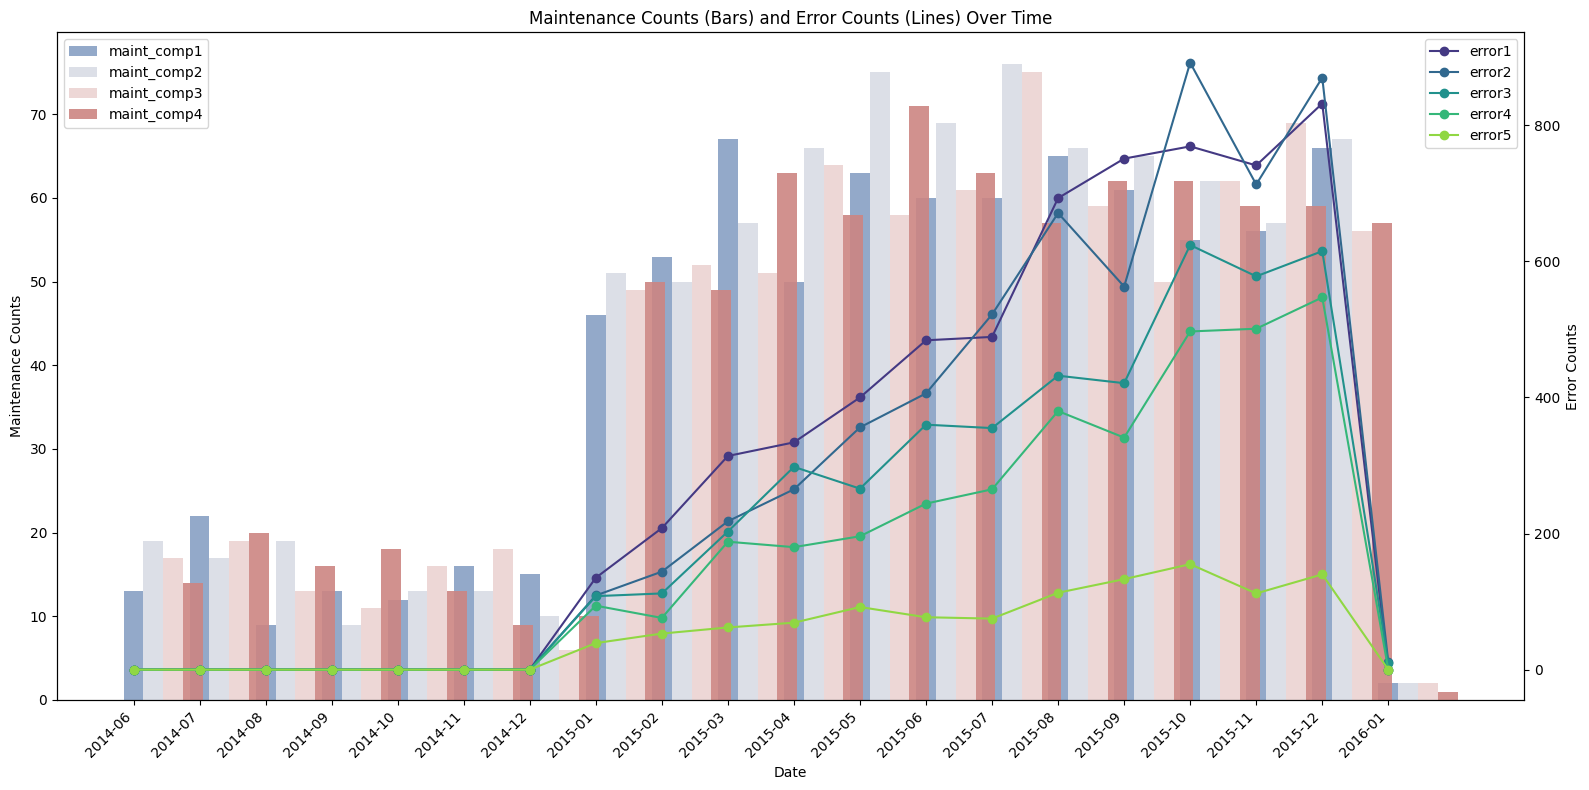

In [67]:
#  Compare maintenance and error counts over time.

error_columns = [col for col in error_maint_combined_df.columns if col.startswith('error')]
maint_columns = [col for col in error_maint_combined_df.columns if col.startswith('maint_comp')]

x = np.arange(len(error_maint_combined_df.index))
bar_width = 0.3

fig, ax1 = plt.subplots(figsize=(16, 8))

ax2 = ax1.twinx()

bar_color = sns.color_palette('vlag', len(maint_columns))

for i, col in enumerate(maint_columns):
    ax1.bar(
        x + i * bar_width,  # Shift each bar group slightly
        error_maint_combined_df[col],
        width=bar_width,
        label=col,
        color=bar_color[i],
        alpha=0.9
    )

line_color = sns.color_palette('viridis', len(error_columns))

for i, col in enumerate(error_columns):
    ax2.plot(
        x, 
        error_maint_combined_df[col], 
        label=col, 
        marker='o', 
        color=line_color[i]
    )


ax1.set_xlabel('Date')
ax1.set_ylabel('Maintenance Counts')
ax2.set_ylabel('Error Counts')


ax1.set_title('Maintenance Counts (Bars) and Error Counts (Lines) Over Time')


ax1.set_xticks(x)
ax1.set_xticklabels(error_maint_combined_df.index.strftime('%Y-%m'), rotation=45, ha='right')


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')


plt.tight_layout()
plt.show()


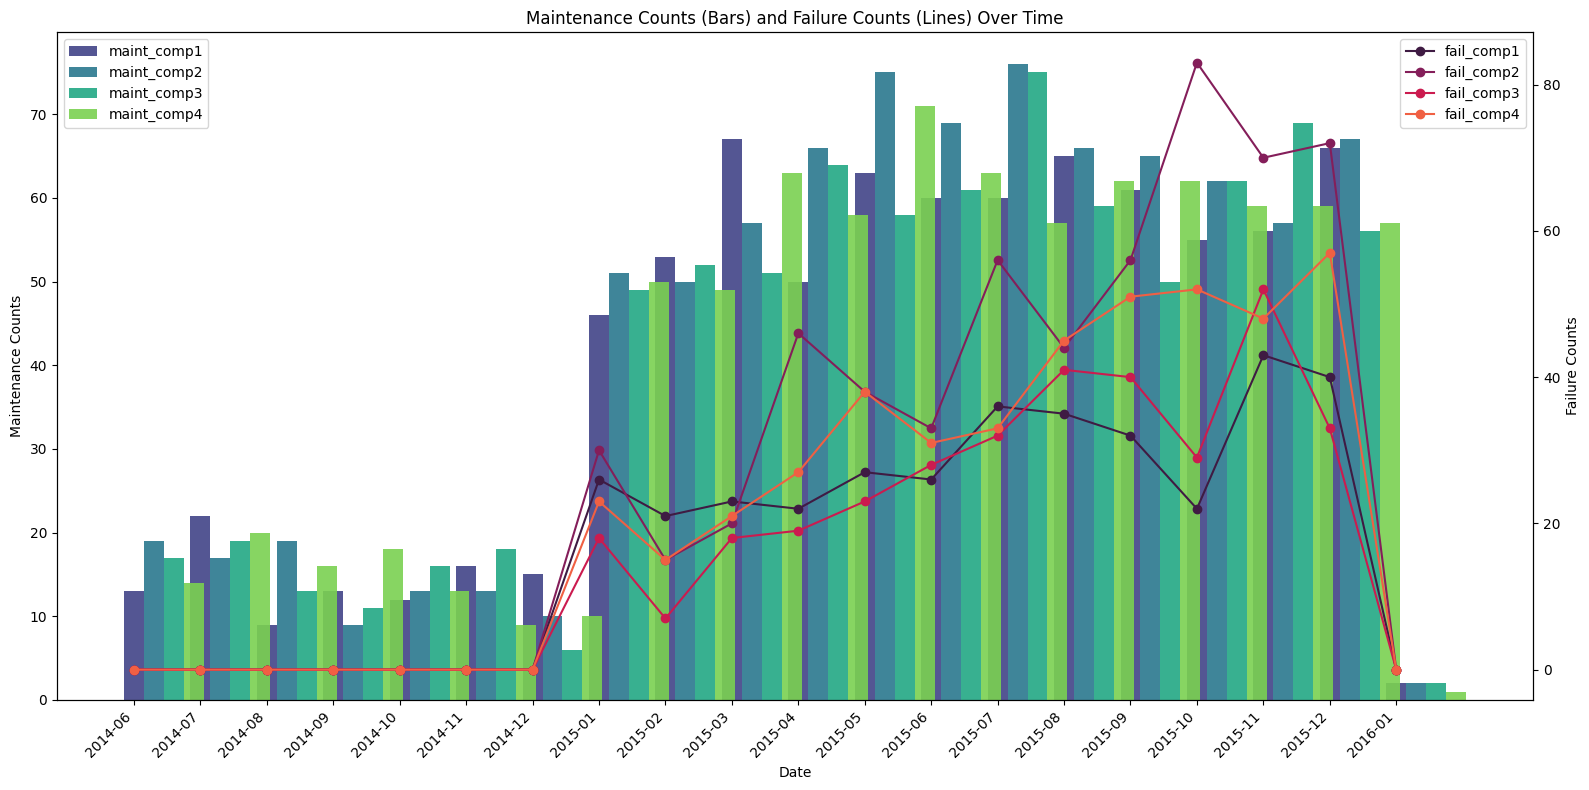

In [68]:
# Compares maintenance counts with failure counts.

failure_columns = [col for col in failure_maint_combined_df.columns if col.startswith('fail')]
maint_columns = [col for col in failure_maint_combined_df.columns if col.startswith('maint_comp')]

x = np.arange(len(failure_maint_combined_df.index))
bar_width = 0.3

fig, ax1 = plt.subplots(figsize=(16, 8))

ax2 = ax1.twinx()

bar_color = sns.color_palette('viridis', len(maint_columns))

for i, col in enumerate(maint_columns):
    ax1.bar(
        x + i * bar_width,  # Shift each bar group slightly
        failure_maint_combined_df[col],
        width=bar_width,
        label=col,
        color=bar_color[i],
        alpha=0.9
    )

line_color = sns.color_palette('rocket', len(error_columns))

for i, col in enumerate(failure_columns):
    ax2.plot(
        x, 
        failure_maint_combined_df[col], 
        label=col, 
        marker='o', 
        color=line_color[i]
    )


ax1.set_xlabel('Date')
ax1.set_ylabel('Maintenance Counts')
ax2.set_ylabel('Failure Counts')


ax1.set_title('Maintenance Counts (Bars) and Failure Counts (Lines) Over Time')


ax1.set_xticks(x)
ax1.set_xticklabels(failure_maint_combined_df.index.strftime('%Y-%m'), rotation=45, ha='right')



ax1.legend(loc='upper left')
ax2.legend(loc='upper right')


plt.tight_layout()
plt.show()


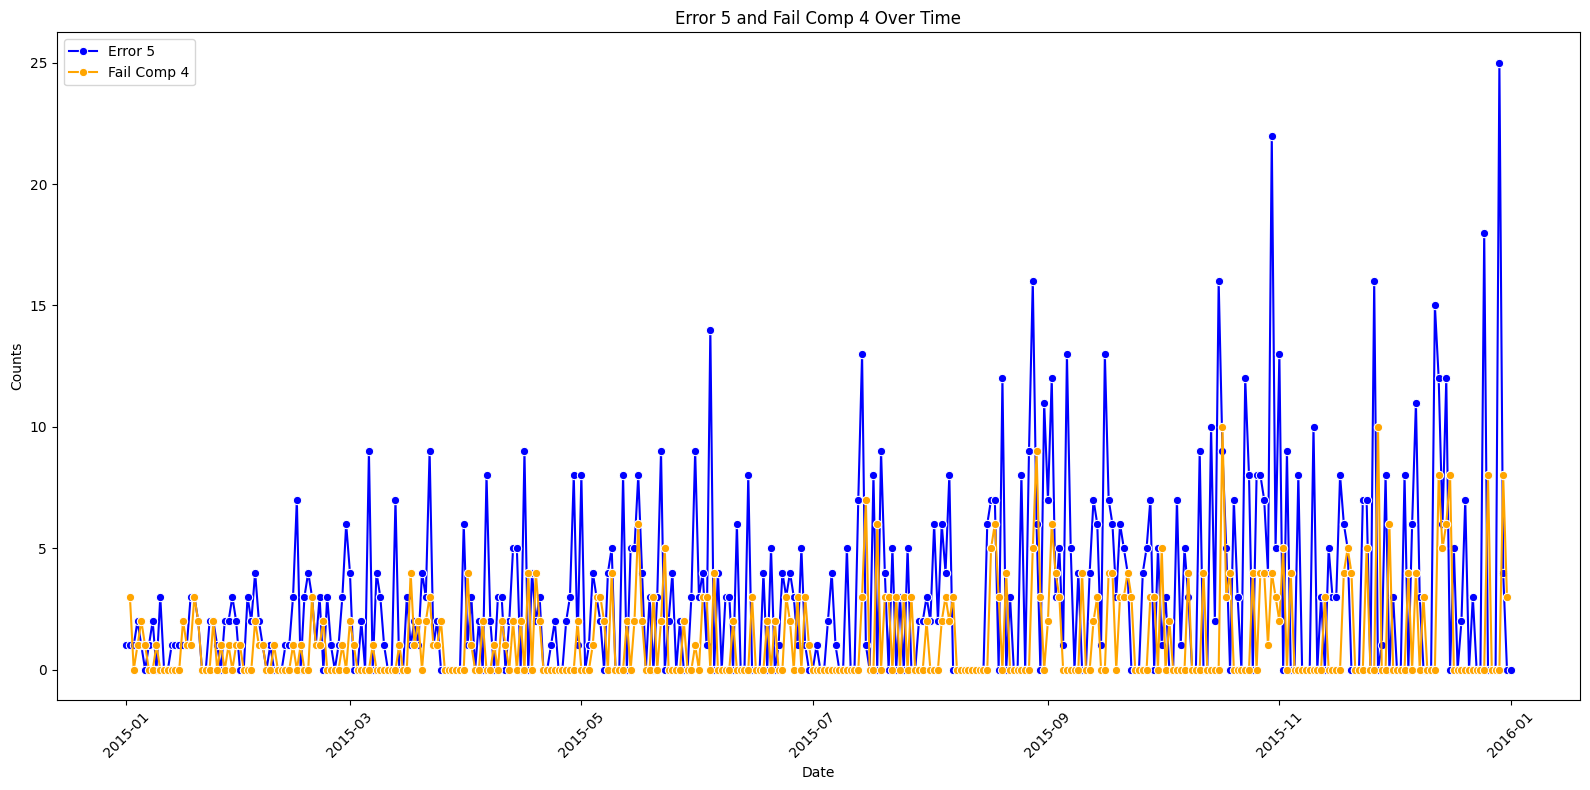

In [69]:
# Looking for patterns, compares Error 5 and Fail Comp 4 over time.
error5 = errors_resampled_days.T['error5']  
fail_comp4 = failures_resampled_days.T['fail_comp4']  


plt.figure(figsize=(16, 8))

sns.lineplot(x=error5.index, y=error5, label='Error 5', marker='o', color='blue')


sns.lineplot(x=fail_comp4.index, y=fail_comp4, label='Fail Comp 4', marker='o', color='orange')


plt.title('Error 5 and Fail Comp 4 Over Time')
plt.xlabel('Date')
plt.ylabel('Counts')


plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()


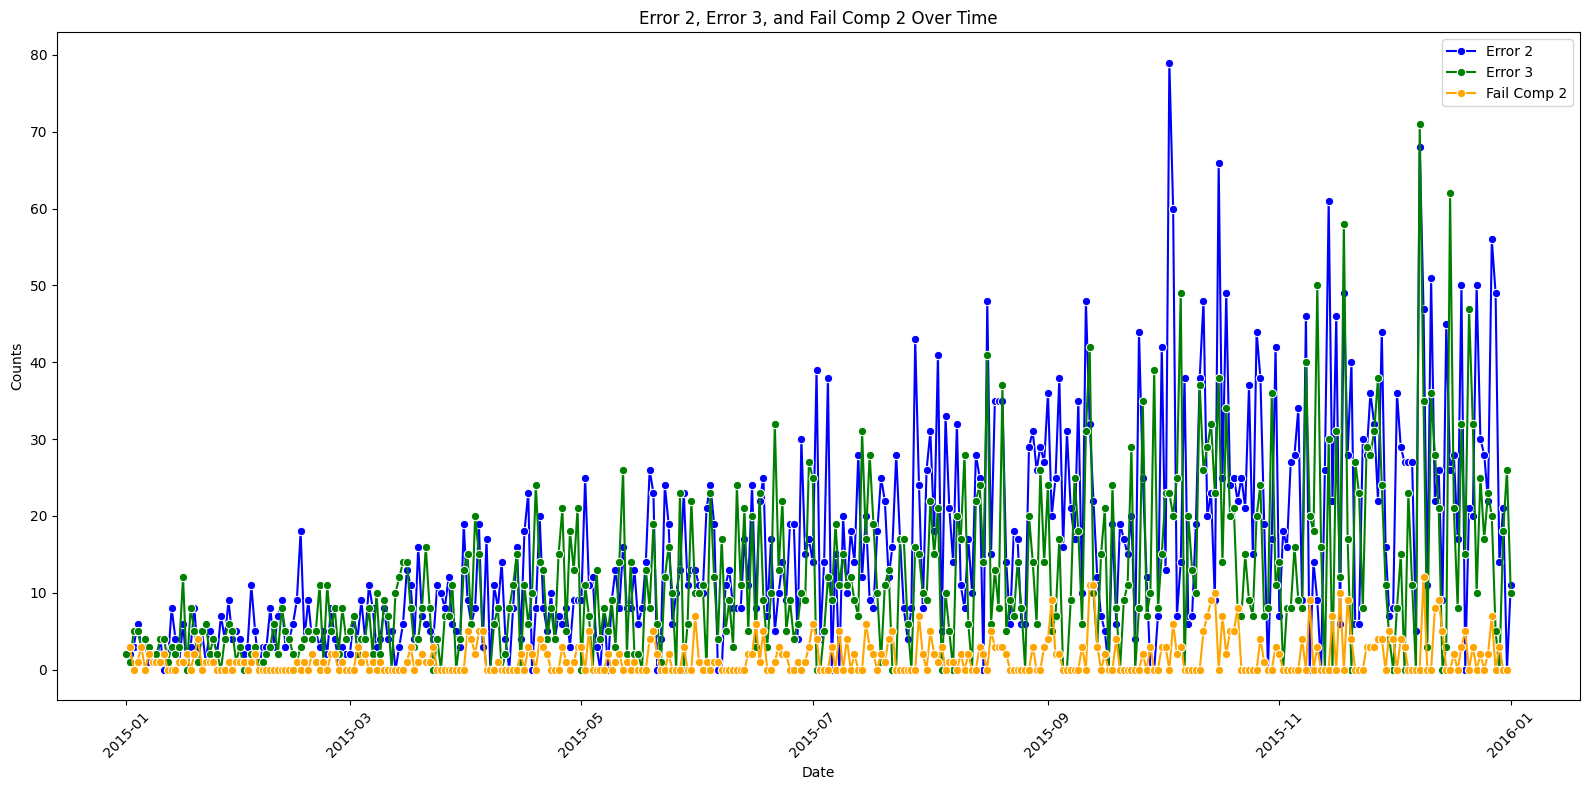

In [70]:
# Looking for patterns, compares Error 2 and 3 and Fail Comp 2 over time.

error2 = errors_resampled_days.T['error2']
error3 = errors_resampled_days.T['error3']
fail_comp2 = failures_resampled_days.T['fail_comp2']


plt.figure(figsize=(16, 8))

sns.lineplot(x=error2.index, y=error2, label='Error 2', marker='o', color='blue')


sns.lineplot(x=error3.index, y=error3, label='Error 3', marker='o', color='green')


sns.lineplot(x=fail_comp2.index, y=fail_comp2, label='Fail Comp 2', marker='o', color='orange')


plt.title('Error 2, Error 3, and Fail Comp 2 Over Time')
plt.xlabel('Date')
plt.ylabel('Counts')


plt.xticks(rotation=45)


plt.legend()
plt.tight_layout()
plt.show()


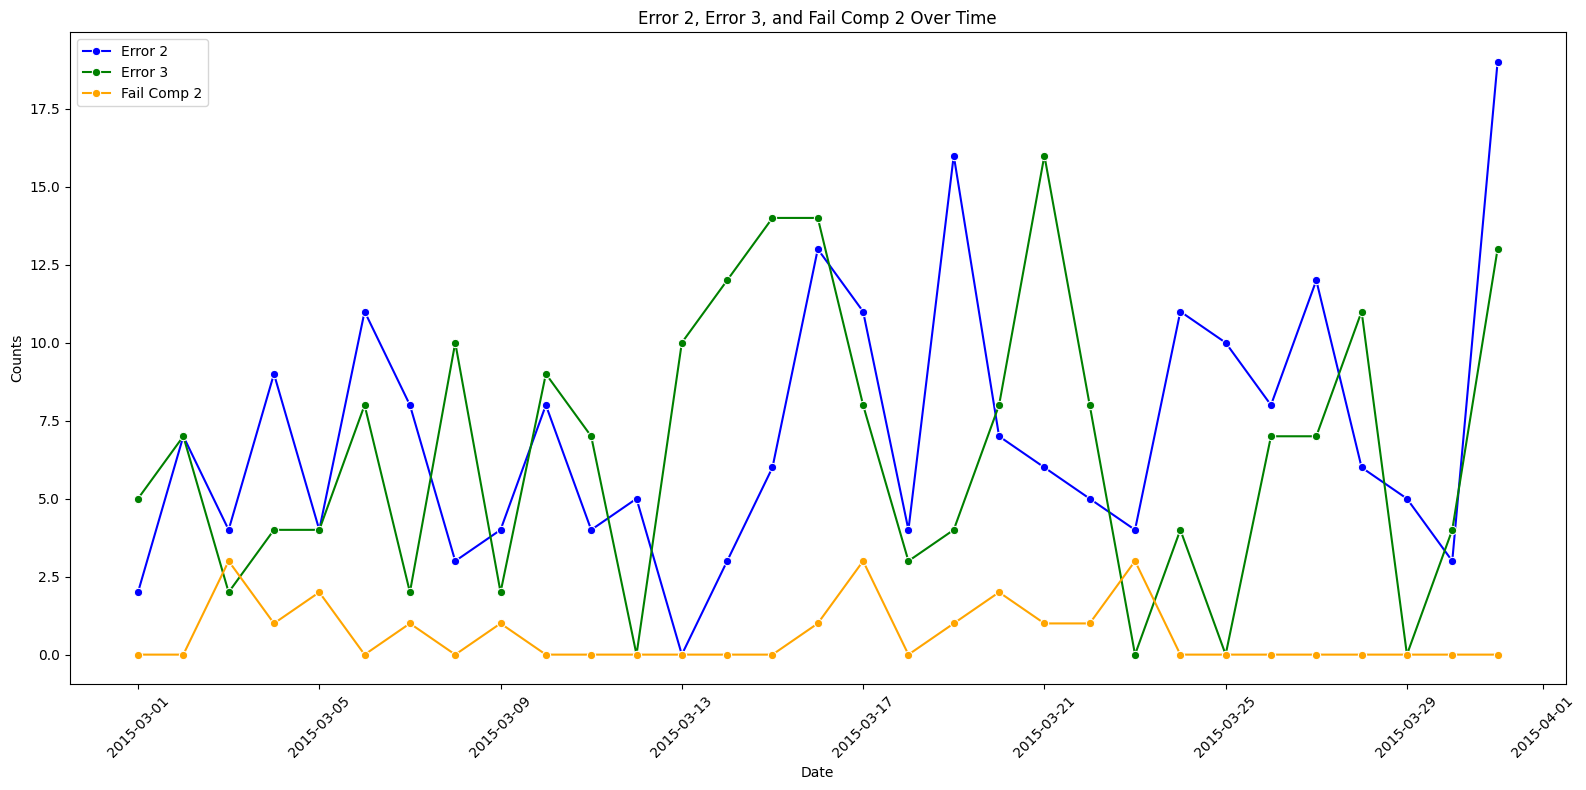

In [71]:
# Zooming in on march month, looking for patterns.

march_2015 = '2015-03'

error2_march = errors_resampled_days.T['error2'].loc[march_2015]
error3_march = errors_resampled_days.T['error3'].loc[march_2015]
fail_comp2_march = failures_resampled_days.T['fail_comp2'].loc[march_2015]


plt.figure(figsize=(16, 8))


sns.lineplot(x=error2_march.index, y=error2_march, label='Error 2', marker='o', color='blue')


sns.lineplot(x=error3_march.index, y=error3_march, label='Error 3', marker='o', color='green')


sns.lineplot(x=fail_comp2_march.index, y=fail_comp2_march, label='Fail Comp 2', marker='o', color='orange')


plt.title('Error 2, Error 3, and Fail Comp 2 Over Time')
plt.xlabel('Date')
plt.ylabel('Counts')


plt.xticks(rotation=45)


plt.legend()
plt.tight_layout()
plt.show()


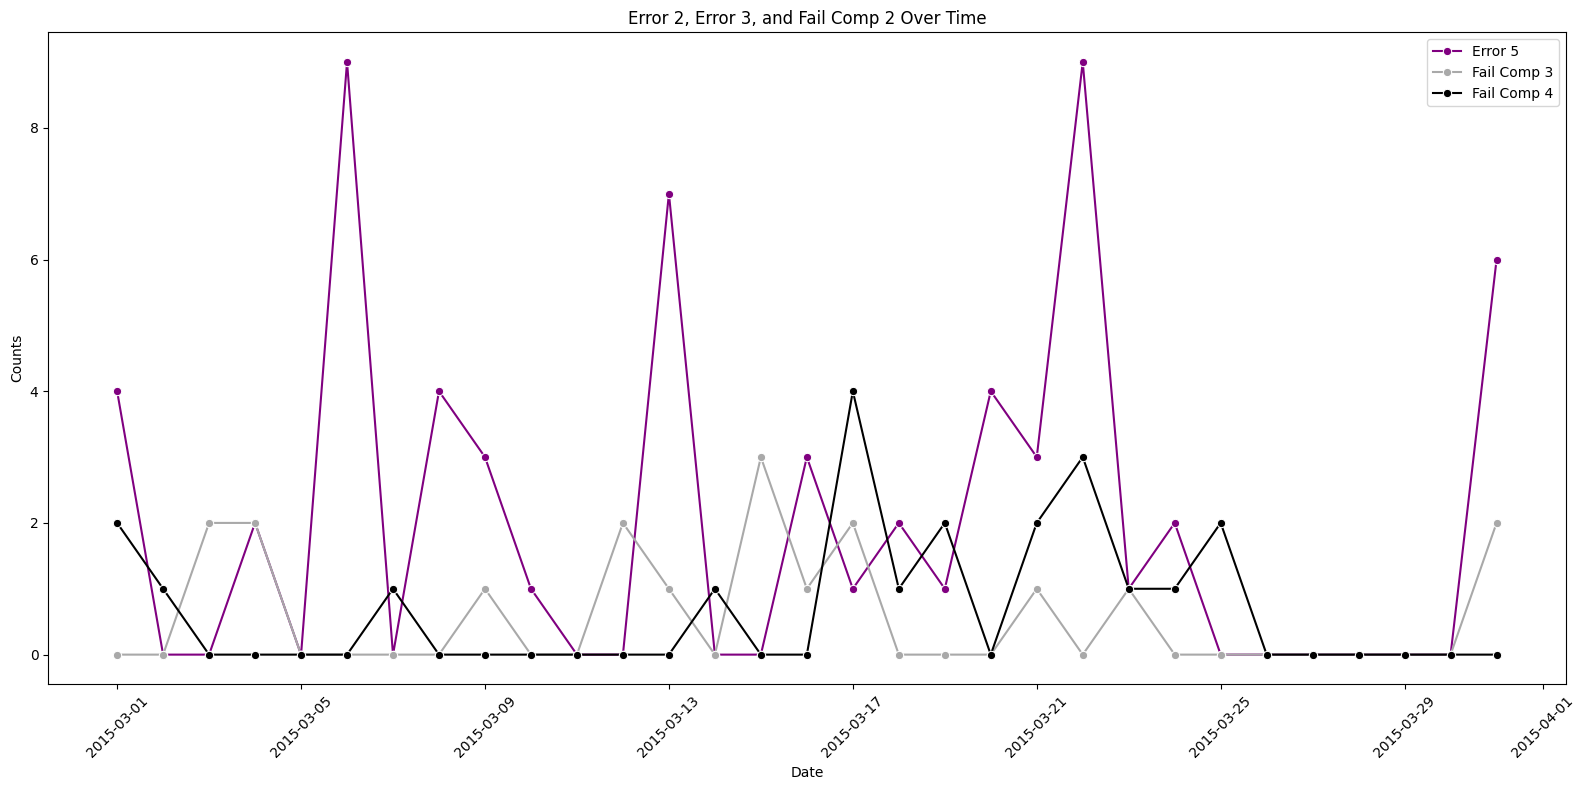

In [72]:
# Zooming in on march month for all errors and failures looking for patterns.

march_2015 = '2015-03'

error1 = errors_resampled_days.T['error1'].loc[march_2015]
error2 = errors_resampled_days.T['error2'].loc[march_2015]
error3 = errors_resampled_days.T['error3'].loc[march_2015]
error4 = errors_resampled_days.T['error4'].loc[march_2015]
error5 = errors_resampled_days.T['error5'].loc[march_2015]
fail_comp1 = failures_resampled_days.T['fail_comp1'].loc[march_2015]
fail_comp2 = failures_resampled_days.T['fail_comp2'].loc[march_2015]
fail_comp3 = failures_resampled_days.T['fail_comp3'].loc[march_2015]
fail_comp4 = failures_resampled_days.T['fail_comp4'].loc[march_2015]


plt.figure(figsize=(16, 8))

#sns.lineplot(x=error1.index, y=error1, label='Error 1', marker='o', color='blue')

#sns.lineplot(x=error2.index, y=error2, label='Error 2', marker='o', color='red')

#sns.lineplot(x=error3.index, y=error3, label='Error 3', marker='o', color='green')

#sns.lineplot(x=error4.index, y=error4, label='Error 4', marker='o', color='orange')

sns.lineplot(x=error5.index, y=error5, label='Error 5', marker='o', color='purple')

#----------------------------------------------------------------------------------------------------------------------------------

#sns.lineplot(x=fail_comp1.index, y=fail_comp1, label='Fail Comp 1', marker='o', color='black')

#sns.lineplot(x=fail_comp2.index, y=fail_comp2, label='Fail Comp 2', marker='o', color='black')

sns.lineplot(x=fail_comp3.index, y=fail_comp3, label='Fail Comp 3', marker='o', color='darkgray')

sns.lineplot(x=fail_comp4.index, y=fail_comp4, label='Fail Comp 4', marker='o', color='black')


plt.title('Error 2, Error 3, and Fail Comp 2 Over Time')
plt.xlabel('Date')
plt.ylabel('Counts')


plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()
plt.show()





In [73]:
cleaned_df1.dtypes
print(type(cleaned_df1['errorID'].iloc[-1]))  
cleaned_df4['comp'].unique()
cleaned_df1['errorID'].unique()
cleaned_df3['model'].unique()

<class 'str'>


array(['model3', 'model4', 'model2', 'model1'], dtype=object)

In [74]:
### 
# Calculates how much time has passed since a certain machine or component 
# last failed. 
# It measures the time in hours between each failure of a component, 
# helping us understand how often it fails and how reliable it is. 
# NaN means that there is no data available for the "time since last failure" 
# because it’s the first failure recorded for that machine or component.
###



df2['date'] = df2['date'].astype(str)
df2['time'] = df2['time'].astype(str)
df2['datetime'] = pd.to_datetime(df2['date'] + ' ' + df2['time'])
df2 = df2.drop(columns=['date', 'time'])



df2 = df2.sort_values(by=['machineID', 'datetime'])
df2['time_since_last_failure'] = df2.groupby(['machineID', 'failure'])['datetime'].diff().dt.total_seconds() / 3600  
print(df2.head())

   machineID failure            datetime  time_since_last_failure
0          1   comp4 2015-01-05 06:00:00                      NaN
1          1   comp1 2015-03-06 06:00:00                      NaN
2          1   comp2 2015-04-20 06:00:00                      NaN
3          1   comp4 2015-06-19 06:00:00                   3960.0
4          1   comp4 2015-09-02 06:00:00                   1800.0


In [75]:
# Tracks how many times each specific component has failed over time 
# for each machine. 

df2= df2.sort_values(by=['machineID', 'datetime'])

df2['component_failure_count'] = df2.groupby(['machineID', 'failure']).cumcount() + 1
df2

,machineID,failure,datetime,time_since_last_failure,component_failure_count
0,1,comp4,2015-01-05 06:00:00,NaN,1
1,1,comp1,2015-03-06 06:00:00,NaN,1
2,1,comp2,2015-04-20 06:00:00,NaN,1
3,1,comp4,2015-06-19 06:00:00,3960.0,2
4,1,comp4,2015-09-02 06:00:00,1800.0,3
...,...,...,...,...,...
756,99,comp3,2015-11-29 06:00:00,2160.0,6
757,99,comp4,2015-12-14 06:00:00,1080.0,5
758,100,comp1,2015-02-12 06:00:00,NaN,1
759,100,comp1,2015-09-10 06:00:00,5040.0,2


In [76]:
cleaned_df1.columns

Index(['machineID', 'errorID', 'datetime', 'component_error_count'], dtype='object')

In [77]:
cleaned_df1['date'] = cleaned_df1['date'].astype(str)
cleaned_df1['time'] = cleaned_df1['time'].astype(str)
cleaned_df1['datetime'] = pd.to_datetime(cleaned_df1['date'] + ' ' + cleaned_df1['time'])
df1 = df1.drop(columns=['date', 'time'])

# Tracks how many times each specific component has had an error over 
# time for each machine. This feature can help identify components 
# that are prone to repeated errors, potentially signaling the need 
# for replacement or more frequent maintenance.

cleaned_df1= cleaned_df1.sort_values(by=['machineID', 'datetime'])

cleaned_df1['component_error_count'] = cleaned_df1.groupby(['machineID', 'errorID']).cumcount() + 1
cleaned_df1

KeyError: 'date'

In [227]:
df4.head()


,machineID,comp,date,time
0,1,comp2,2014-06-01,06:00
1,1,comp4,2014-07-16,06:00
2,1,comp3,2014-07-31,06:00
3,1,comp1,2014-12-13,06:00
4,1,comp4,2015-01-05,06:00


In [ ]:
#Show which components failed during each event. This allows tracking
# of failures by component to see patterns across components.


components = cleaned_df2['failure'].unique()  

for component in components:
    cleaned_df2[f'failure_{component}'] = (cleaned_df2['failure'] == component).astype(int)
    

cleaned_df2

In [ ]:
#Calculate the maintenance interval to determine the days between 
# consecutive maintenance events for each component on each machine. 
# This feature helps us understand the maintenance history and can be used 
# to predict when the next maintenance or failure might occur. 

df4['date'] = pd.to_datetime(df4['date'])

df4 = df4.sort_values(by=['machineID', 'comp', 'date'])

df4['maintenance_interval'] = df4.groupby(['machineID', 'comp'])['date'].diff().dt.days
df4

In [ ]:
cleaned_df3.head()
print(type(cleaned_df3['model'].iloc[-1])) 

In [ ]:
cleaned_df4['comp'].unique()

In [145]:


window_size = '12h' # Use h for hours and D for days to get rolling average 


cleaned_df5['volt_rolling_mean'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['volt'].mean().reset_index(drop=True)
cleaned_df5['volt_rolling_std'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['volt'].std().fillna(0).reset_index(drop=True)

cleaned_df5['rotate_rolling_mean'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['rotate'].mean().reset_index(drop=True)
cleaned_df5['rotate_rolling_std'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['rotate'].std().fillna(0).reset_index(drop=True)

cleaned_df5['pressure_rolling_mean'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['pressure'].mean().reset_index(drop=True)
cleaned_df5['pressure_rolling_std'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['pressure'].std().fillna(0).reset_index(drop=True)

cleaned_df5['vibration_rolling_mean'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['vibration'].mean().reset_index(drop=True)
cleaned_df5['vibration_rolling_std'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['vibration'].std().fillna(0).reset_index(drop=True)


cleaned_df5.head(10)

,machineID,volt,rotate,pressure,vibration,datetime,volt_rolling_mean,volt_rolling_std,rotate_rolling_mean,rotate_rolling_std,pressure_rolling_mean,pressure_rolling_std,vibration_rolling_mean,vibration_rolling_std
0,1,176.217853,418.504078,113.077935,45.087686,2015-01-01 06:00:00,176.217853,0.000000,418.504078,0.000000,113.077935,0.000000,45.087686,0.000000
1,1,162.879223,402.747490,95.460525,43.413973,2015-01-01 07:00:00,169.548538,9.431836,410.625784,11.141591,104.269230,12.457390,44.250829,1.183494
2,1,170.989902,527.349825,75.237905,34.178847,2015-01-01 08:00:00,170.028993,6.721032,449.533798,67.849599,94.592122,18.934956,40.893502,5.874970
3,1,162.462833,346.149335,109.248561,41.122144,2015-01-01 09:00:00,168.137453,6.665324,423.687682,75.770259,98.256232,17.109194,40.950662,4.798255
4,1,157.610021,435.376873,111.886648,25.990511,2015-01-01 10:00:00,166.031967,7.448844,426.025520,65.826868,100.982315,16.021893,37.958632,7.875828
5,1,172.504839,430.323362,95.927042,35.655017,2015-01-01 11:00:00,167.110779,7.167373,426.741827,58.903479,100.139769,14.478264,37.574696,7.106854
6,1,156.556031,499.071623,111.755684,42.753920,2015-01-01 12:00:00,165.602958,7.663161,437.074655,60.321814,101.799186,13.926919,38.314585,6.776542
7,1,172.522781,409.624717,101.001083,35.482009,2015-01-01 13:00:00,166.467935,7.504690,433.643413,56.684136,101.699423,12.896909,37.960513,6.353286
8,1,175.324524,398.648781,110.624361,45.482287,2015-01-01 14:00:00,167.452001,7.615497,429.755120,54.291106,102.691083,12.425356,38.796266,6.450198
9,1,169.218423,460.850670,104.848230,39.901735,2015-01-01 15:00:00,167.628643,7.201655,432.864675,52.122115,102.906797,11.734582,38.906813,6.091345


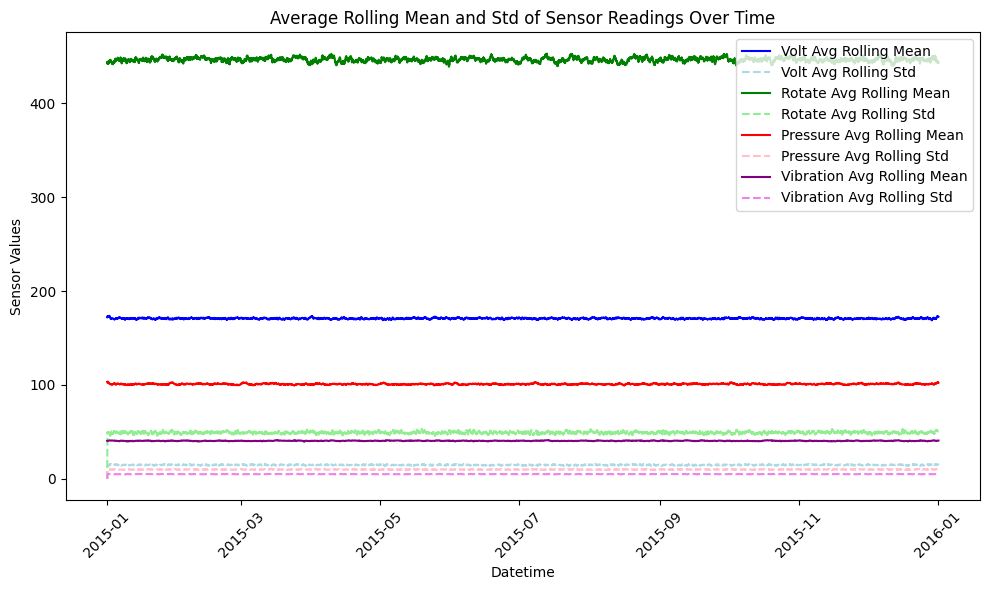

In [141]:



avg_df = cleaned_df5.groupby('datetime').agg({
    'volt_rolling_mean': 'mean',
    'volt_rolling_std': 'mean',
    'rotate_rolling_mean': 'mean',
    'rotate_rolling_std': 'mean',
    'pressure_rolling_mean': 'mean',
    'pressure_rolling_std': 'mean',
    'vibration_rolling_mean': 'mean',
    'vibration_rolling_std': 'mean'
}).reset_index()

colors = {
    'volt_mean': 'blue',
    'volt_std': 'lightblue',
    'rotate_mean': 'green',
    'rotate_std': 'lightgreen',
    'pressure_mean': 'red',
    'pressure_std': 'pink',
    'vibration_mean': 'purple',
    'vibration_std': 'violet'
}
plt.figure(figsize=(10, 6))

sns.lineplot(x='datetime', y='volt_rolling_mean', data=avg_df, color=colors['volt_mean'], label='Volt Avg Rolling Mean')
sns.lineplot(x='datetime', y='volt_rolling_std', data=avg_df, color=colors['volt_std'], linestyle='--', label='Volt Avg Rolling Std')

sns.lineplot(x='datetime', y='rotate_rolling_mean', data=avg_df, color=colors['rotate_mean'], label='Rotate Avg Rolling Mean')
sns.lineplot(x='datetime', y='rotate_rolling_std', data=avg_df, color=colors['rotate_std'], linestyle='--', label='Rotate Avg Rolling Std')

sns.lineplot(x='datetime', y='pressure_rolling_mean', data=avg_df, color=colors['pressure_mean'], label='Pressure Avg Rolling Mean')
sns.lineplot(x='datetime', y='pressure_rolling_std', data=avg_df, color=colors['pressure_std'], linestyle='--', label='Pressure Avg Rolling Std')

sns.lineplot(x='datetime', y='vibration_rolling_mean', data=avg_df, color=colors['vibration_mean'], label='Vibration Avg Rolling Mean')
sns.lineplot(x='datetime', y='vibration_rolling_std', data=avg_df, color=colors['vibration_std'], linestyle='--', label='Vibration Avg Rolling Std')

plt.title('Average Rolling Mean and Std of Sensor Readings Over Time')
plt.xlabel('Datetime')
plt.ylabel('Sensor Values')

plt.xticks(rotation=45)
plt.tight_layout()

plt.legend(loc='upper right')
plt.show()


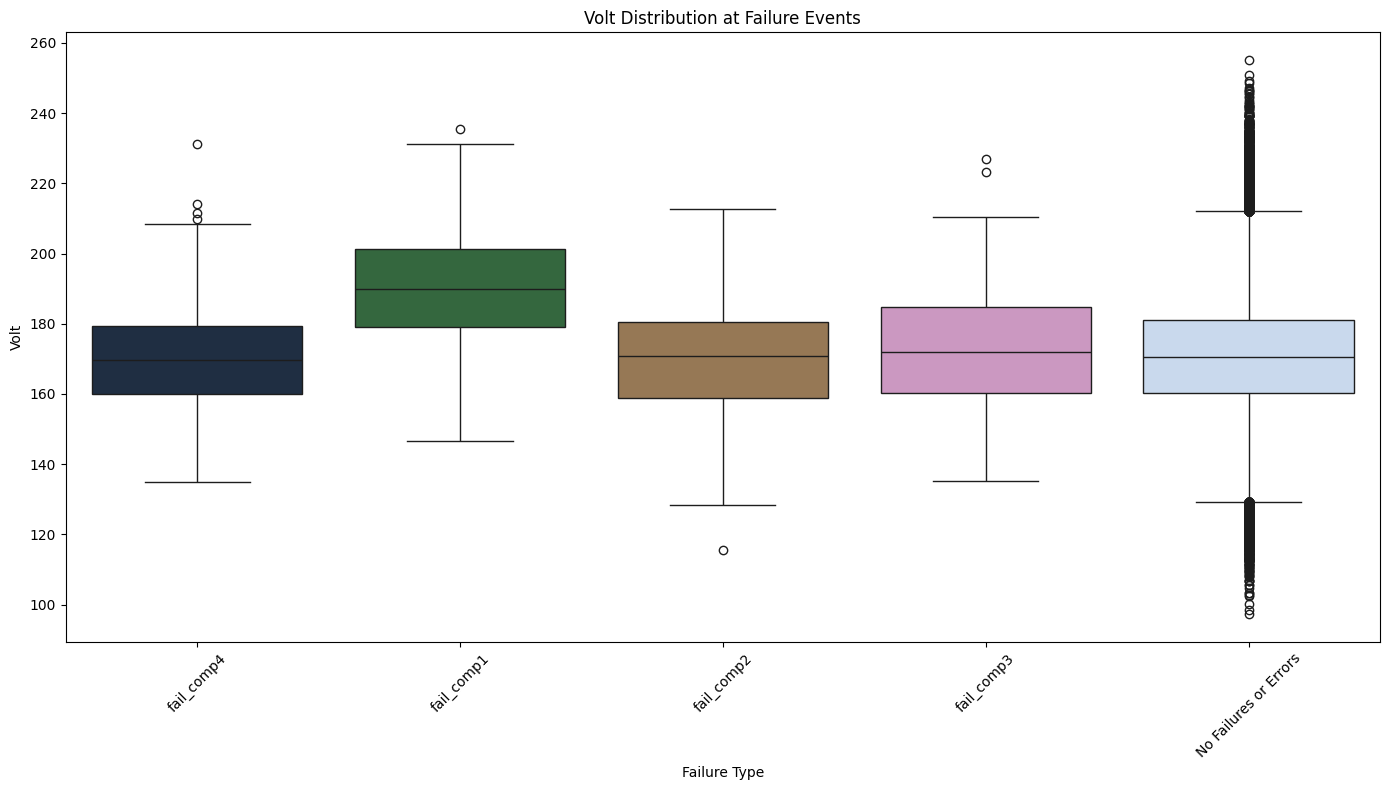

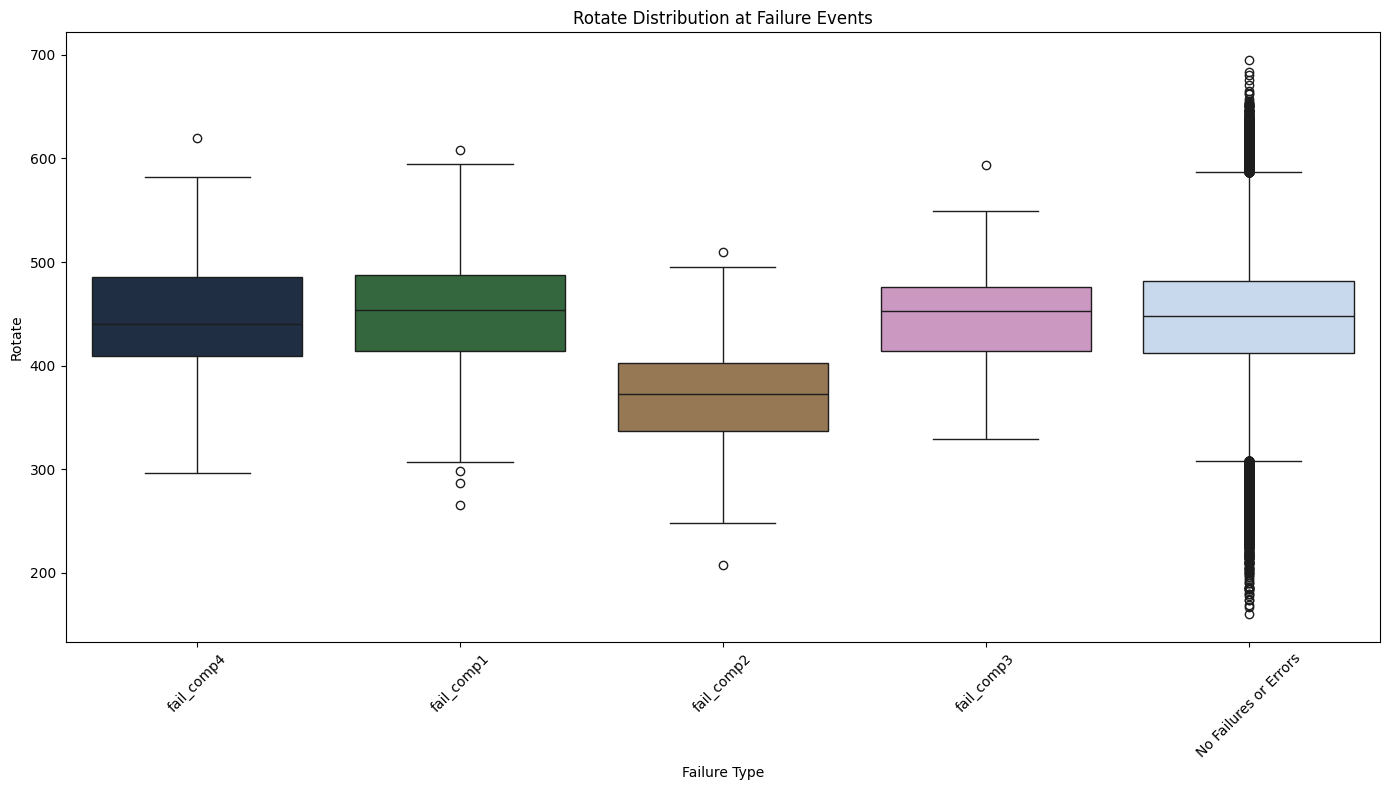

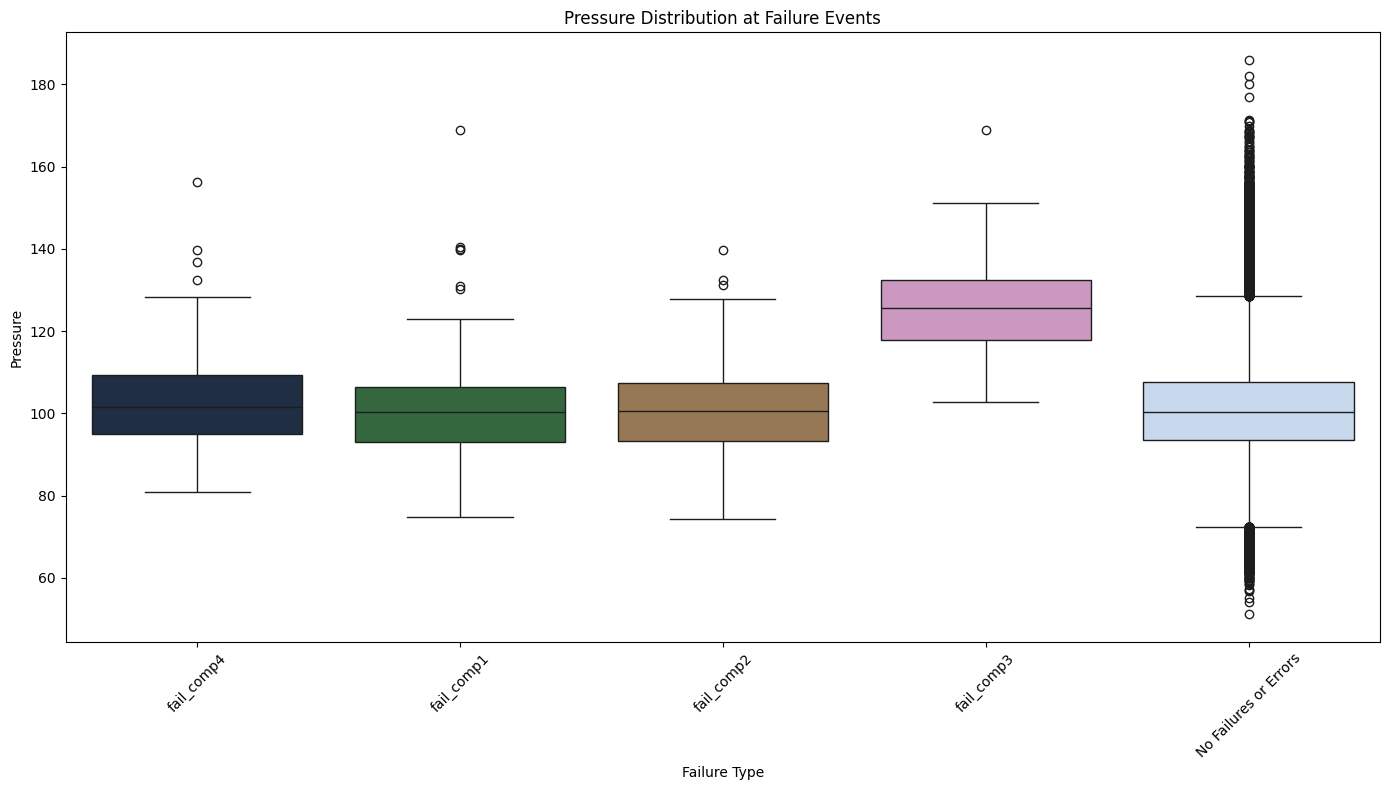

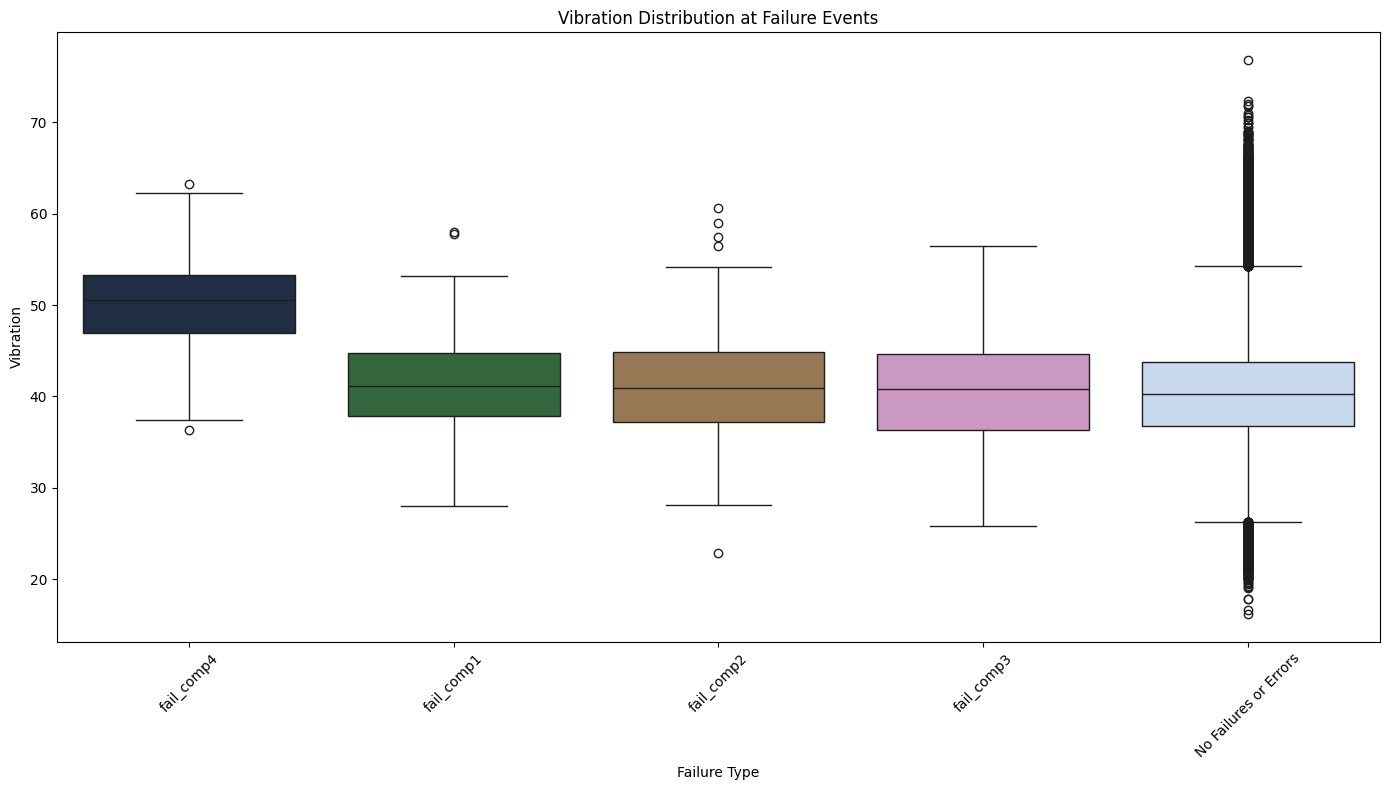

In [84]:
# Analyze the relationship between telemetry readings (voltage, rotation, pressure, and vibration) 
# and failure events for different machines using boxplots. 
# Inferences: 
#           Voltage: Higher voltage levels seem to be associated with failures in component 1, 
#                    as its distribution is centered around a higher range compared to other failures.
#                    The distribution for "No Failures or Errors" shows a wider range with many 
#                    outliers, indicating occasional high voltage spikes that did not lead to failures.
#           
#           Rotation: Failures in component 2 tend to occur at lower rotation speeds, suggesting 
#                     that lower speed might stress this component more.
#
#           Pressure: Component 3 failures occur at a relatively higher pressure range, suggesting a 
#                   sensitivity to increased pressure.
#
#           Vibration: Failures in component 4 are associated with a higher range of vibration.

telemetry_for_failures = pd.merge(
    cleaned_df2,
    cleaned_df5,
    on=['datetime', 'machineID'],
    how='inner'  # Telemetry readings for each failure.
)

# Telemetry for non error and non failure sensor data.
failure_dates = cleaned_df2['datetime']
error_dates = cleaned_df1['datetime']
no_fail_no_error_telemetry = cleaned_df5[
    ~cleaned_df5['datetime'].isin(failure_dates) & 
    ~cleaned_df5['datetime'].isin(error_dates)
].copy()

no_fail_no_error_telemetry['failure'] = 'No Failures or Errors'

combined_telemetry_for_failures = pd.concat([telemetry_for_failures, no_fail_no_error_telemetry], ignore_index=True)

telemetry_columns = ['volt', 'rotate', 'pressure', 'vibration']

palette = 'cubehelix'
for column in telemetry_columns:
    plt.figure(figsize=(14,8))
    sns.boxplot(data=combined_telemetry_for_failures, x='failure', y=column, hue = 'failure', palette=palette)
    plt.title(f'{column.capitalize()} Distribution at Failure Events')
    plt.xlabel('Failure Type')
    plt.ylabel(column.capitalize())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




mamma är bäst och en pro


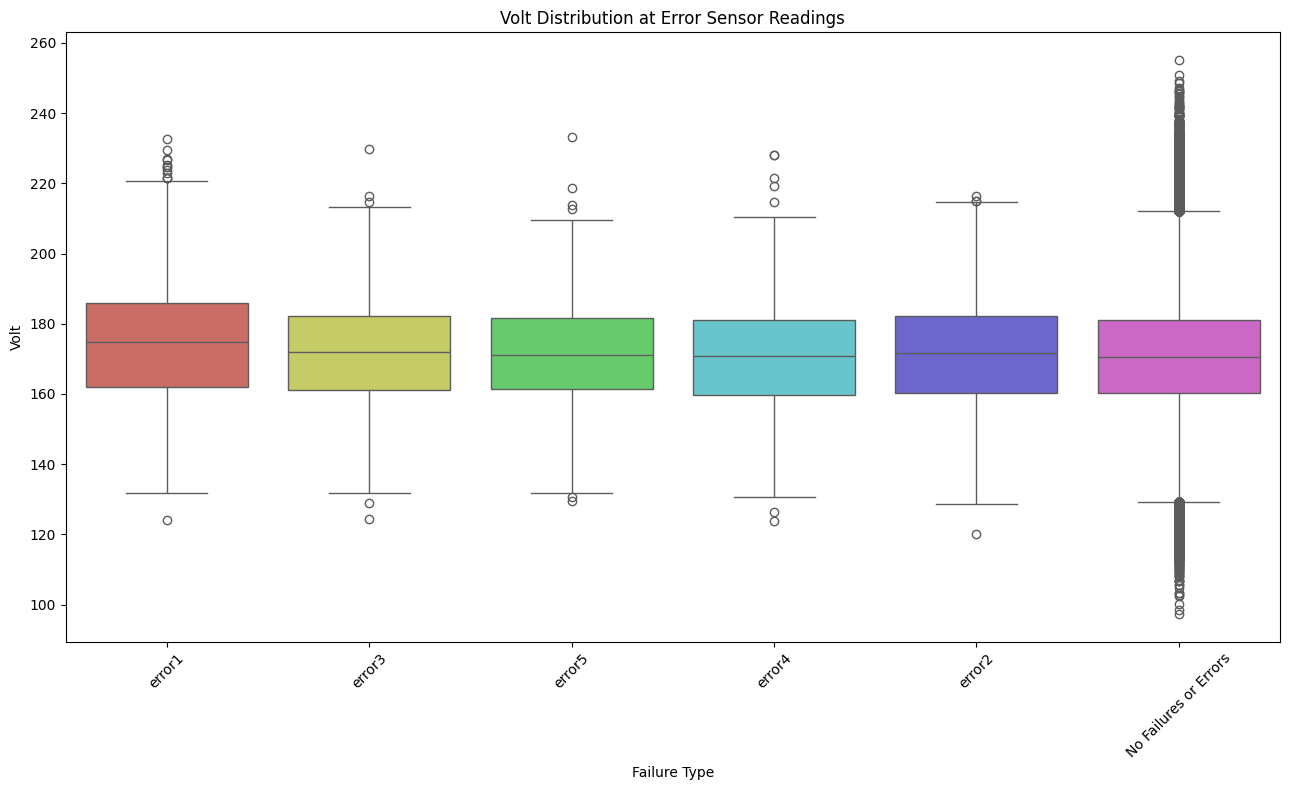

mamma är bäst och en pro


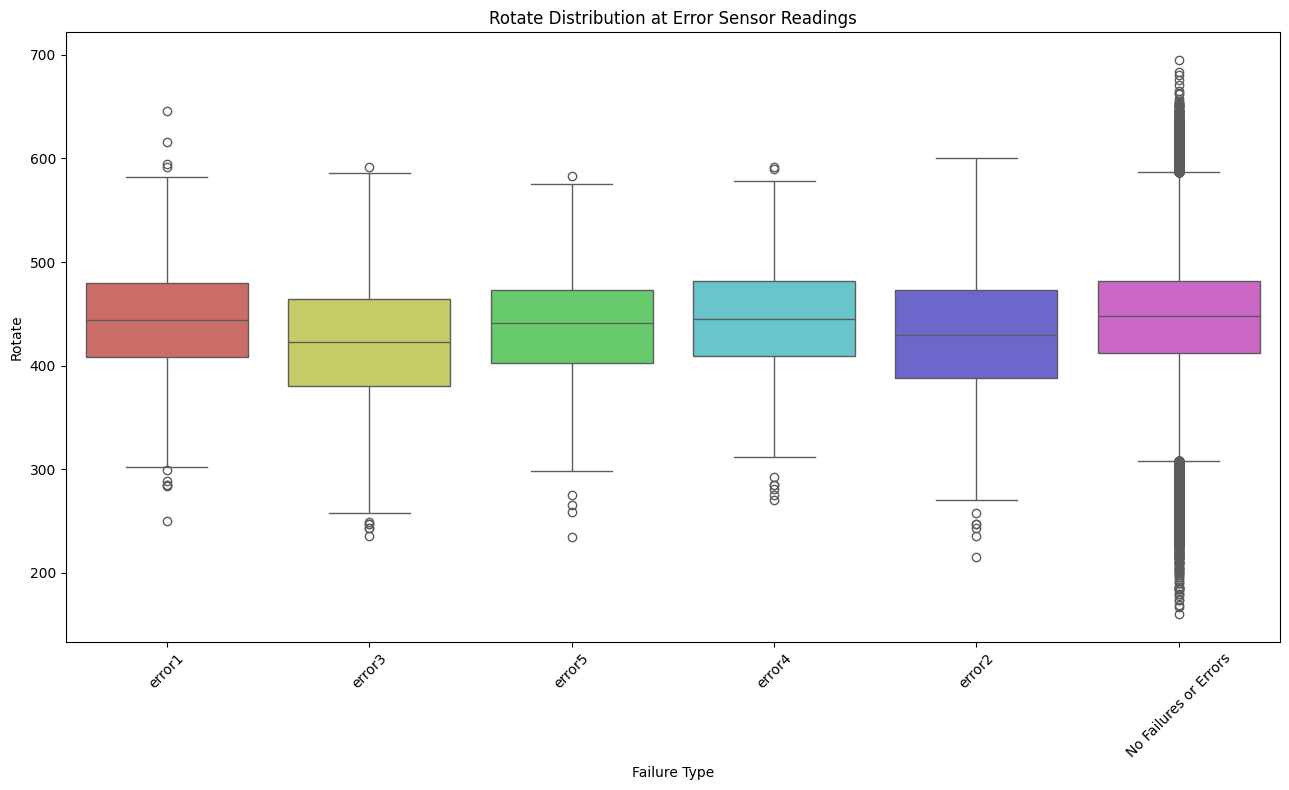

mamma är bäst och en pro


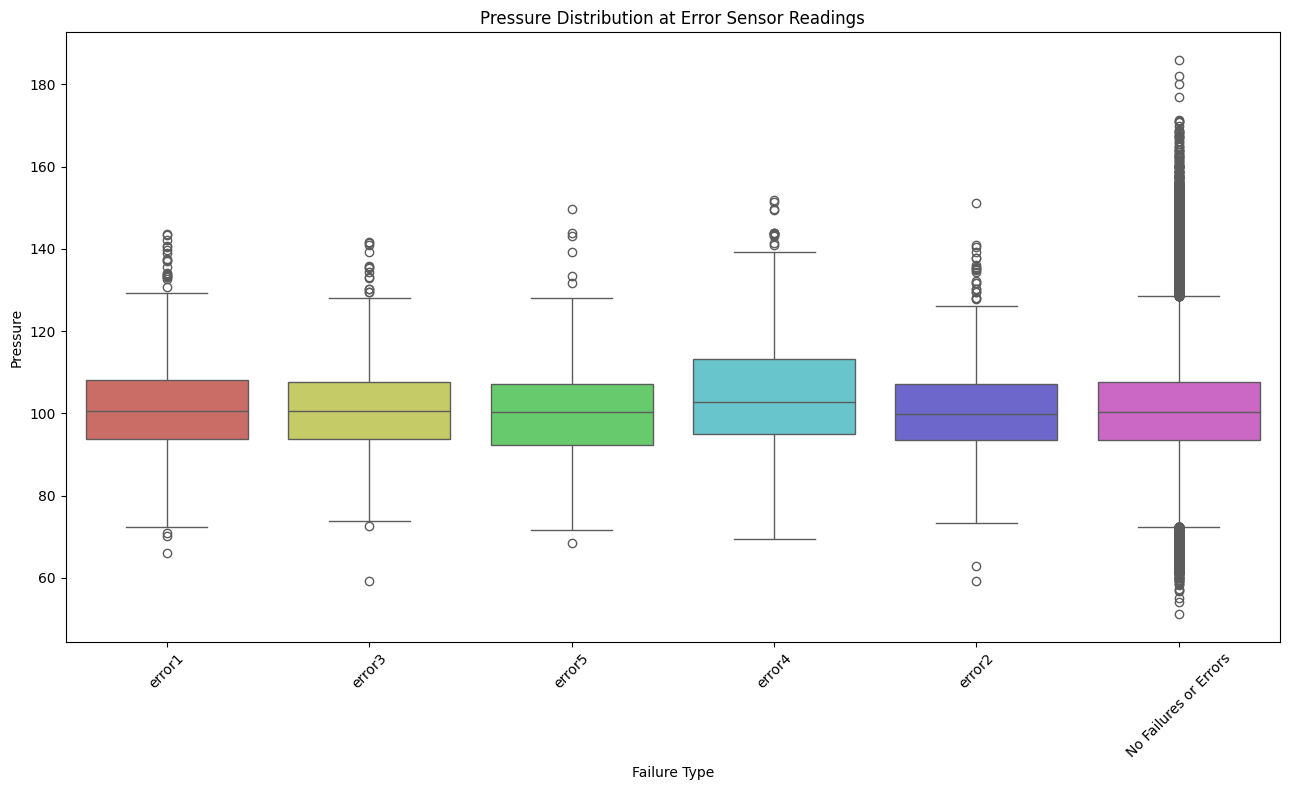

mamma är bäst och en pro


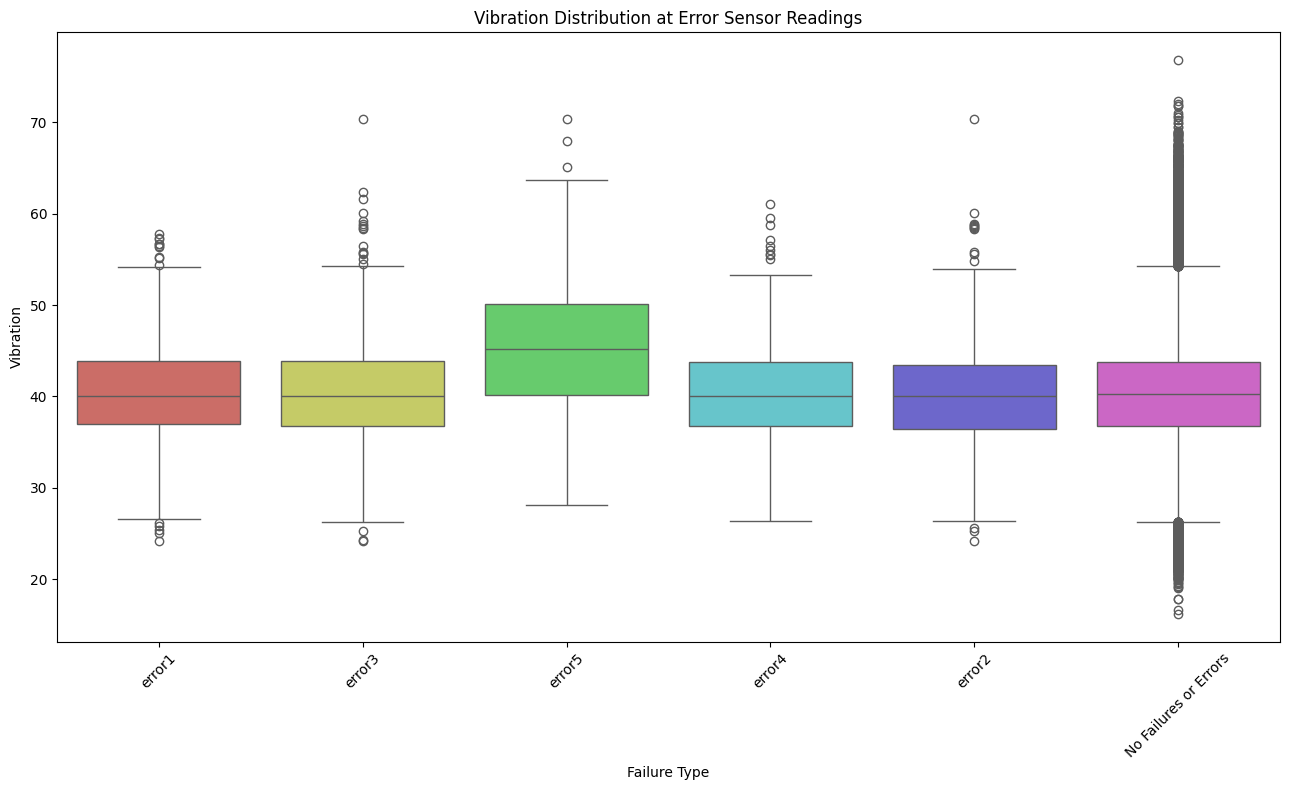

In [101]:
# Analyze the relationship between telemetry readings (voltage, rotation, pressure, and vibration) 
# and error events for different machines using boxplots. 
# Inferences: 
#           Voltage: A slight increase in voltage is associated with error 1.
#           
#           Rotation: A slightly lower rotation is associated with error 2 and 3.
#
#           Pressure: A slight increase in pressure is associated with error 4.
#
#           Vibration: A slight increase in vibration is associate with error 5.

telemetry_for_errors = pd.merge(
    cleaned_df1,
    cleaned_df5,
    on=['datetime', 'machineID'],
    how='inner'  # Telemetry readings for each error type.
)

no_fail_no_error_telemetry['errorID'] = 'No Failures or Errors'

combined_telemetry_for_errors = pd.concat([telemetry_for_errors, no_fail_no_error_telemetry], ignore_index=True)

telemetry_columns = ['volt', 'rotate', 'pressure', 'vibration']

palette = 'hls'
for column in telemetry_columns:
    plt.figure(figsize=(13, 8))
    sns.boxplot(data=combined_telemetry_for_errors, x='errorID', y=column, hue = 'errorID', palette=palette)
    plt.title(f'{column.capitalize()} Distribution at Error Sensor Readings')
    plt.xlabel('Failure Type')
    plt.ylabel(column.capitalize())
    plt.xticks(rotation=45)
    plt.tight_layout()
    print("mamma är bäst och en pro")
    plt.show()


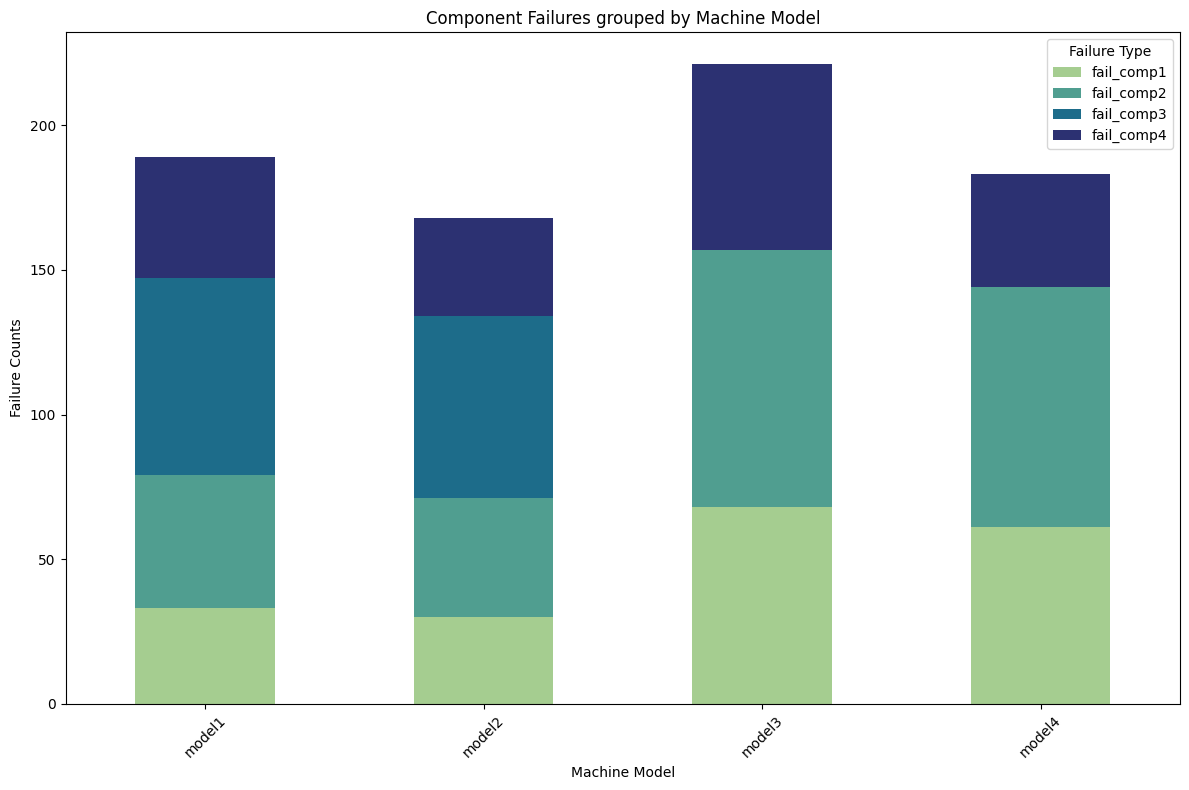

In [146]:
# Analyze how different machine models experience failures through grouping failures by type and model.
# Are there machine models that are more prone to specific types of failures?
#
# Observations:  
#           * Model 1 and Model 3 have the highest number of failures overall, especially for component 4.
#           * Model 2 has the least amount of failures, with a significant number of failures for component 3.
#           * Model 3 and 4 do not have any failures with component 3. 
#           * Model 3 has the most even distribution of failures (exception being no failures with component 3)
#           * Model 4 is much like model 3, but with less failures in component 4.
# 
# Inference:
#           * Failure in component 3 is absent in Model 3 and Model 4, but this seems to be associated with 
#             a higher failure rate in component 2 and component 1.
#           * Model 4 shows fewer failures in component 4, suggesting that some issues with component 4 
#             have been addressed or improved in this model.


failures_with_model = pd.merge(
                            cleaned_df2,
                            cleaned_df3,
                            on='machineID',
                            how='left')

failures_by_model = failures_with_model.groupby(['model', 'failure']).size().unstack(fill_value=0)

failures_by_model.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='crest')

plt.title('Component Failures grouped by Machine Model')
plt.xlabel('Machine Model')
plt.ylabel('Failure Counts')

plt.legend(title='Failure Type', loc='upper right')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [131]:
# Calculates the age of machine components before each replacement. This helps in understanding 
# how long each component lasts. It determines the time between replacements for each component 
# and the average age across all machines.
#
# Observation: Components last around 24 days on average before being replaced.
# It would be interesting to further investigate whether this lifespan differs 
# between different machine models.

# This will give the age of the component before each replacement. Where there is
# no previous replacement to compare to a 0 will be placed.
cleaned_df4['comp_age_days'] = cleaned_df4.groupby(['machineID', 'comp'])['datetime'].diff().dt.days.fillna(0)

avg_comp_age = cleaned_df4.groupby('comp')['comp_age_days'].mean().reset_index()

avg_comp_age.columns = ['Component', 'Average Age (Days)']

print(avg_comp_age)


     Component  Average Age (Days)
0  maint_comp1           24.256757
1  maint_comp2           23.741007
2  maint_comp3           22.972973
3  maint_comp4           24.807692


In [145]:
# Calculates the age of machine components before each replacement for different models.
# This helps in understanding how long components last across various machine models.
#
# Observations:
#             * Model 1 has the highest average component age for component 4 at 30.68 days,
#               indicating that component 4 lasts longer in this model compared to others.
#             * Model 2 generally has the shortest component lifespan for component 4 at 21.63 days,
#               suggesting that component 4 may need more frequent replacements in Model 2.
#             * Model 3 shows relatively consistent component ages, averaging between 22.92 and 23.95 days,
#               suggesting stable replacement intervals across components.
# Inference: Combined with an earlier observation that there are no failures for component 3 in Model 3 and 4,
#            these observations suggest that maintenance intervals may be effectively preventing failures.
           



cleaned_df4 = pd.merge(
                cleaned_df4, 
                cleaned_df3[['machineID', 'model']], 
                on='machineID', 
                how='left')

avg_comp_age_by_model = cleaned_df4.groupby(['model', 'comp'])['comp_age_days'].mean().reset_index()

print(avg_comp_age_by_model)


     model         comp  comp_age_days
0   model1  maint_comp1      26.500000
1   model1  maint_comp2      25.263158
2   model1  maint_comp3      21.818182
3   model1  maint_comp4      30.681818
4   model2  maint_comp1      24.729730
5   model2  maint_comp2      24.687500
6   model2  maint_comp3      22.241379
7   model2  maint_comp4      21.627907
8   model3  maint_comp1      23.958333
9   model3  maint_comp2      22.920000
10  model3  maint_comp3      23.895349
11  model3  maint_comp4      22.916667
12  model4  maint_comp1      23.493976
13  model4  maint_comp2      23.731343
14  model4  maint_comp3      22.702703
15  model4  maint_comp4      25.000000


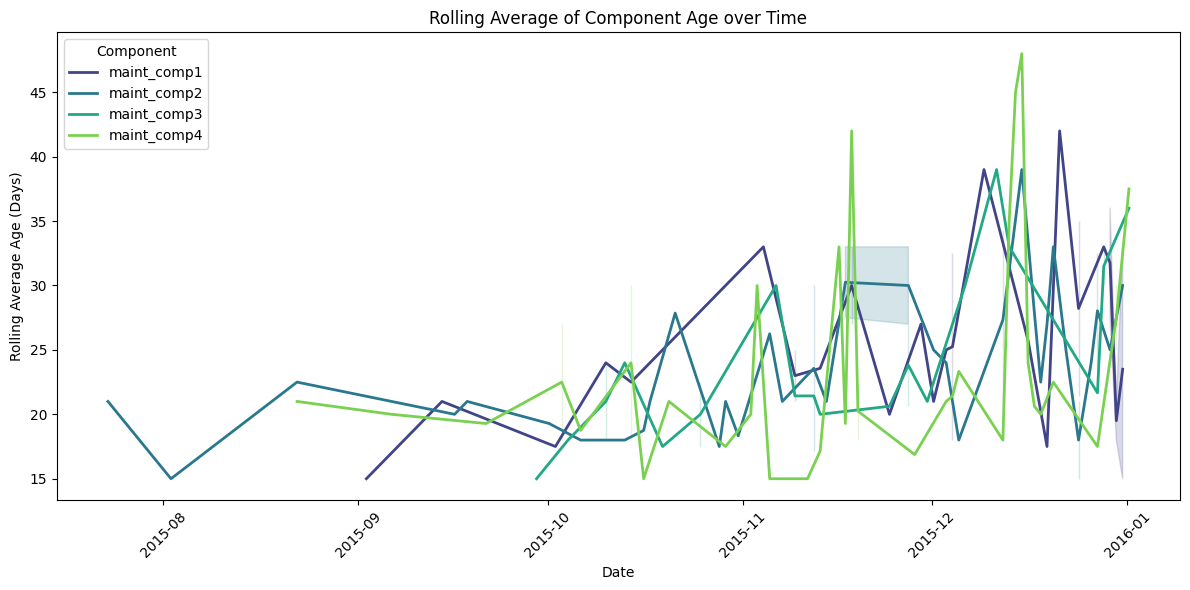

In [144]:
# Calculates the rolling average of component age over a 30-day replacement window.
# The rolling average is used to smooth out short-term fluctuations and provides a
# clearer view of the trends in component longevity over time.
#
# Observation: The rolling average of component age is highly variable over time,
# suggesting that the replacement interval for each component fluctuates significantly
# with no clear steady trend.

# To smooth out the curve and highlight any trends, increase the window size and/or 
# the minimum number of data points required in the window before calculating the average.
cleaned_df4['comp_age_rolling_mean'] = (
    cleaned_df4
    .groupby(['machineID', 'comp'])['comp_age_days']
    .transform(lambda x: x.rolling(window=30, min_periods=1).mean())
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cleaned_df4,
    x='datetime',
    y='comp_age_rolling_mean',
    hue='comp',
    palette='viridis',
    linewidth=2
)

plt.title('Rolling Average of Component Age over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Average Age (Days)')

plt.xticks(rotation=45)
plt.legend(title='Component', loc='upper left')

plt.tight_layout()
plt.show()


In [126]:
# Checking for correlation between sensor readings and machine failures. Do they help
# predict failures?
#
# Inference: The correlation values are very close to zero, which suggests that 
#            there’s very little connection between individual sensor readings and 
#            machine failures.
#            The next logical step would be to explore interactions between the sensor 
#            readings, meaning combinations of readings might be more informative for 
#            predicting failures.

telemetry_fail_corr_df = pd.merge(
                            cleaned_df5, 
                            cleaned_df2[['machineID', 'datetime', 'failure']], 
                            on=['machineID', 'datetime'], 
                            how='left')


telemetry_fail_corr_df['failure_binary'] = telemetry_fail_corr_df['failure'].notnull().astype(int)

sensor_columns = ['volt', 'rotate', 'pressure', 'vibration']
correlation = telemetry_failures_corr_df[sensor_columns + ['failure_binary']].corr()

print(correlation['failure_binary'].sort_values(ascending=False))


failure_binary    1.000000
vibration         0.015323
pressure          0.012741
volt              0.008988
rotate           -0.014352
Name: failure_binary, dtype: float64


In [127]:
# Exploring interactions between the sensor readings.
#
# Observataion: The highest correlation with machine failures is for the 
#               pressure-vibration interaction, but this is still very low.
# Inference: Weak predictivness because the interaction terms do not show any 
#            strong correlation for machine failures. A deep learning model 
#            like LSTM, GRU or even a TCN might be able to see the more 
#            complex relationship.


telemetry_fail_corr_df['volt_pressure_interaction'] = (
    telemetry_fail_corr_df['volt'] * telemetry_fail_corr_df['pressure'])
telemetry_fail_corr_df['volt_rotate_interaction'] = (
    telemetry_fail_corr_df['volt'] * telemetry_fail_corr_df['rotate'])
telemetry_fail_corr_df['volt_vibration_interaction'] = (
    telemetry_fail_corr_df['volt'] * telemetry_fail_corr_df['vibration'])

telemetry_fail_corr_df['rotate_pressure_interaction'] = (
    telemetry_fail_corr_df['rotate'] * telemetry_fail_corr_df['pressure'])
telemetry_fail_corr_df['rotate_vibration_interaction'] = (
    telemetry_fail_corr_df['rotate'] * telemetry_fail_corr_df['vibration'])

telemetry_fail_corr_df['pressure_vibration_interaction'] = (
    telemetry_fail_corr_df['pressure'] * telemetry_fail_corr_df['vibration'])


interaction_columns = [
    'volt_pressure_interaction', 
    'volt_rotate_interaction', 
    'volt_vibration_interaction', 
    'rotate_pressure_interaction', 
    'rotate_vibration_interaction', 
    'pressure_vibration_interaction'
]

correlation_interactions = (
    telemetry_fail_corr_df[interaction_columns + ['failure_binary']].corr())

print(correlation_interactions)


                                volt_pressure_interaction  \
volt_pressure_interaction                        1.000000   
volt_rotate_interaction                          0.387177   
volt_vibration_interaction                       0.360351   
rotate_pressure_interaction                      0.520269   
rotate_vibration_interaction                     0.001098   
pressure_vibration_interaction                   0.488543   
failure_binary                                   0.015541   

                                volt_rotate_interaction  \
volt_pressure_interaction                      0.387177   
volt_rotate_interaction                        1.000000   
volt_vibration_interaction                     0.340913   
rotate_pressure_interaction                    0.577701   
rotate_vibration_interaction                   0.522570   
pressure_vibration_interaction                -0.000324   
failure_binary                                -0.005578   

                                volt_v